In [31]:
import pandas as pd
from collections import deque
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv("Data.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1998-10-23 00:00:00+05:30,14.615395,15.427776,14.317274,15.129654,17665237
1,1998-10-26 00:00:00+05:30,15.278712,16.344496,15.278712,16.187983,11531300
2,1998-10-27 00:00:00+05:30,16.314686,17.484813,15.696084,17.112160,21477780
3,1998-10-28 00:00:00+05:30,16.918385,17.693501,16.322142,16.456297,18610023
4,1998-10-29 00:00:00+05:30,16.351948,17.104705,15.964392,16.873661,15478216


In [33]:
data_frame= data.copy()
name = 'Double Q-learning agent'
close = data_frame['Close']

In [34]:
class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

In [35]:
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def purchase(self, initial_money):
        start_money = initial_money
        selling_states = []
        states_purchase = []
        bucket = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                bucket.append(self.trend[t])
                initial_money -= self.trend[t]
                states_purchase.append(t)
                print('day %d: purchase 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(bucket):
                bought_price = bucket.pop(0)
                initial_money += self.trend[t]
                selling_states.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - start_money) / start_money) * 100
        total_gains = initial_money - start_money
        return states_purchase, selling_states, total_gains, invest

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def retrievePredictedAction(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def define(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.retrievePredictedAction([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            bucket = []
            state = self.get_state(0)
            start_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self.define()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and start_money >= self.trend[t]:
                    bucket.append(self.trend[t])
                    start_money -= self.trend[t]
                
                elif action == 2 and len(bucket) > 0:
                    bought_price = bucket.pop(0)
                    total_profit += self.trend[t] - bought_price
                    start_money += self.trend[t]
                    
                invest = ((start_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, start_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, start_money))

In [36]:
close = data_frame.Close.values.tolist()
initial_money = 1_00_000
window_size = 60
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 250, checkpoint = 10, initial_money = initial_money)

c:\Users\ashih\.conda\envs\tf1.15\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 6424.754859.3, cost: 0.311561, total money: 76150.371802
epoch: 20, total rewards: -4739.275130.3, cost: 0.020537, total money: 92616.624894
epoch: 30, total rewards: 10797.885058.3, cost: 0.046330, total money: 108209.935107
epoch: 40, total rewards: 2474.748933.3, cost: 0.014237, total money: 100511.298982
epoch: 50, total rewards: 417.997620.3, cost: 0.002279, total money: 100417.997620
epoch: 60, total rewards: 26.397460.3, cost: 0.001128, total money: 100026.397460
epoch: 70, total rewards: 6693.110072.3, cost: 0.004572, total money: 104666.860072
epoch: 80, total rewards: 430.522146.3, cost: 0.002226, total money: 100430.522146
epoch: 90, total rewards: 1602.031914.3, cost: 0.009903, total money: 101602.031914
epoch: 100, total rewards: 2517.811995.3, cost: 0.000667, total money: 102517.811995
epoch: 110, total rewards: 417.318836.3, cost: 0.000820, total money: 100417.318836
epoch: 120, total rewards: 861.280942.3, cost: 0.003071, total money: 98856.080

KeyboardInterrupt: 

In [37]:
states_purchase, selling_states, total_gains, invest = agent.purchase(initial_money = initial_money)

day 3: purchase 1 unit at price 16.456297, total balance 99983.543703
day 12, sell 1 unit at price 20.003941, investment 21.557971 %, total balance 100003.547644,
day 19: purchase 1 unit at price 21.188971, total balance 99982.358673
day 23: purchase 1 unit at price 19.467319, total balance 99962.891354
day 28: purchase 1 unit at price 17.864916, total balance 99945.026438
day 38, sell 1 unit at price 21.747944, investment 2.638039 %, total balance 99966.774382,
day 41: purchase 1 unit at price 22.769011, total balance 99944.005371
day 44: purchase 1 unit at price 24.788784, total balance 99919.216587
day 46: purchase 1 unit at price 25.660795, total balance 99893.555792
day 52: purchase 1 unit at price 26.614782, total balance 99866.941010
day 55, sell 1 unit at price 30.833195, investment 58.384387 %, total balance 99897.774204,
day 57: purchase 1 unit at price 31.898977, total balance 99865.875227
day 59: purchase 1 unit at price 33.449207, total balance 99832.426020
day 62: purchas

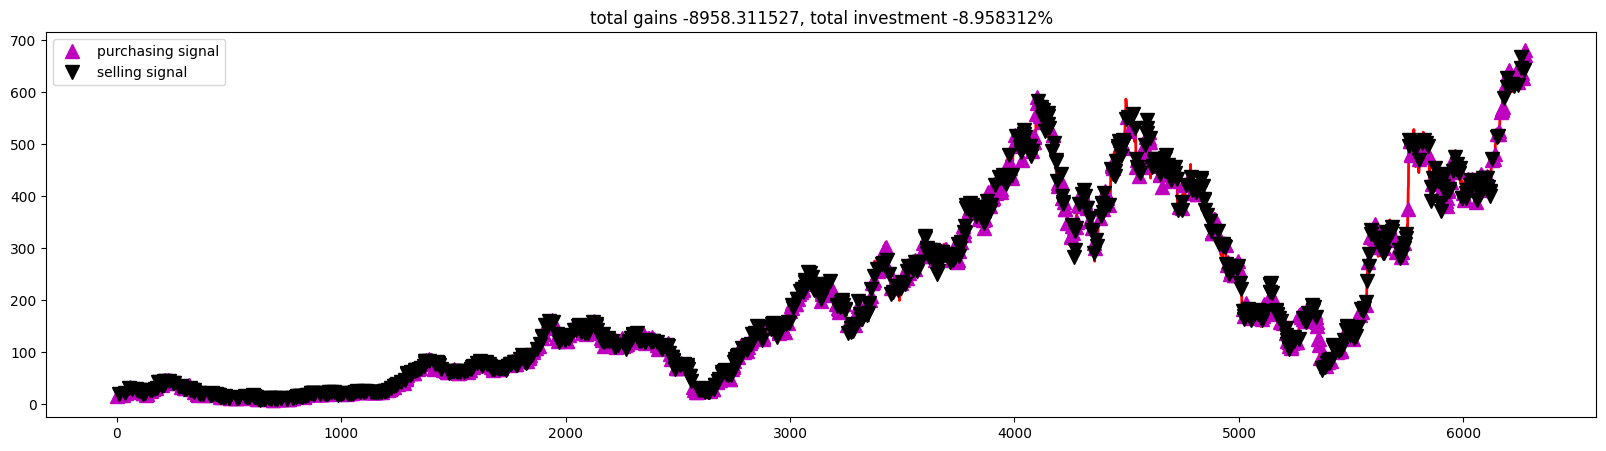

In [38]:
fig = plt.figure(figsize = (20,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'purchasing signal', markevery = states_purchase)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = selling_states)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()